In [1]:
import numpy as np
import pickle
import awkward as ak
import dask_awkward as dak
from distributed import Client

In [2]:
client =  Client(n_workers=31,  threads_per_worker=1, processes=True, memory_limit='4 GiB') 

/depot/cms/kernels/coffea2024/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45475 instead
  warnings.warn(


In [25]:
load_path = "/depot/cms/users/yun79/results/stage1/test_VBF-filter_JECon_07June2024/2018/f1_0/"
full_load_path = load_path+f"/data_C/*/*.parquet"
# full_load_path = load_path+f"data*/*/*.parquet"
# full_load_path = load_path+f"/ggh_powheg/*/*.parquet"
events = dak.from_parquet(full_load_path)
# print(events.fields)
# only select specific fields to load to save run time
events["dimuon_dEta"] = np.abs(events.mu1_pt -events.mu2_pt)
events["dimuon_pt_log"] = np.log(events.dimuon_pt)
events["jj_mass_log"] = np.log(events.jj_mass)
events["ll_zstar_log"] = np.log(events.ll_zstar)
events["mu1_pt_over_mass"] = events.mu1_pt / events.dimuon_mass
events["mu2_pt_over_mass"] = events.mu2_pt / events.dimuon_mass


training_features = [
    'dimuon_cos_theta_cs', 'dimuon_dEta', 'dimuon_dPhi', 'dimuon_dR', 'dimuon_eta', 'dimuon_phi', 'dimuon_phi_cs', 'dimuon_pt', 
    'dimuon_pt_log', 'jet1_eta', 'jet1_phi', 'jet1_pt', 'jet1_qgl', 'jet2_eta', 'jet2_phi', 
    'jet2_pt', 'jet2_qgl', 'jj_dEta', 'jj_dPhi', 'jj_eta', 'jj_mass', 'jj_mass_log', 
    'jj_phi', 'jj_pt', 'll_zstar_log', 'mmj1_dEta', 'mmj1_dPhi', 'mmj2_dEta', 'mmj2_dPhi', 
    'mmj_min_dEta', 'mmj_min_dPhi', 'mmjj_eta', 'mmjj_mass', 'mmjj_phi', 'mmjj_pt', 'mu1_eta', 'mu1_iso', 
    'mu1_phi', 'mu1_pt_over_mass', 'mu2_eta', 'mu2_iso', 'mu2_phi', 'mu2_pt_over_mass', 'zeppenfeld'
]
for training_feature in training_features:
    if training_feature not in events.fields:
        print(f"mssing feature: {training_feature}")

fields2load = training_features + ["h_peak", "h_sidebands", "dimuon_mass", "wgt_nominal_total"]
events = events[fields2load]
# load data to memory using compute()
events = ak.zip({
    field : events[field] for field in events.fields
}).compute()

In [26]:
def prepare_features(df, training_features, variation="nominal", add_year=False):
    #global training_features
    if add_year:
        features = training_features + ["year"]
    else:
        features = training_features
    features_var = []
    #print(features)
    for trf in features:
        if f"{trf}_{variation}" in df.fields:
            features_var.append(f"{trf}_{variation}")
        elif trf in df.fields:
            features_var.append(trf)
        else:
            print(f"Variable {trf} not found in training dataframe!")
    return features_var

    

def evaluate_bdt(df, variation, model, parameters):

    # filter out events neither h_peak nor h_sidebands
    row_filter = (df.h_peak != 0) | (df.h_sidebands != 0)
    df = df[row_filter]
    
    # training_features = ['dimuon_cos_theta_cs', 'dimuon_dEta', 'dimuon_dPhi', 'dimuon_dR', 'dimuon_eta', 'dimuon_phi', 'dimuon_phi_cs', 'dimuon_pt', 'dimuon_pt_log', 'jet1_eta_nominal', 'jet1_phi_nominal', 'jet1_pt_nominal', 'jet1_qgl_nominal', 'jet2_eta_nominal', 'jet2_phi_nominal', 'jet2_pt_nominal', 'jet2_qgl_nominal', 'jj_dEta_nominal', 'jj_dPhi_nominal', 'jj_eta_nominal', 'jj_mass_nominal', 'jj_mass_log_nominal', 'jj_phi_nominal', 'jj_pt_nominal', 'll_zstar_log_nominal', 'mmj1_dEta_nominal', 'mmj1_dPhi_nominal', 'mmj2_dEta_nominal', 'mmj2_dPhi_nominal', 'mmj_min_dEta_nominal', 'mmj_min_dPhi_nominal', 'mmjj_eta_nominal', 'mmjj_mass_nominal', 'mmjj_phi_nominal', 'mmjj_pt_nominal', 'mu1_eta', 'mu1_iso', 'mu1_phi', 'mu1_pt_over_mass', 'mu2_eta', 'mu2_iso', 'mu2_phi', 'mu2_pt_over_mass', 'zeppenfeld_nominal']
    training_features = [
        'dimuon_cos_theta_cs', 'dimuon_dEta', 'dimuon_dPhi', 'dimuon_dR', 'dimuon_eta', 'dimuon_phi', 'dimuon_phi_cs', 'dimuon_pt', 
        'dimuon_pt_log', 'jet1_eta', 'jet1_phi', 'jet1_pt', 'jet1_qgl', 'jet2_eta', 'jet2_phi', 
        'jet2_pt', 'jet2_qgl', 'jj_dEta', 'jj_dPhi', 'jj_eta', 'jj_mass', 'jj_mass_log', 
        'jj_phi', 'jj_pt', 'll_zstar_log', 'mmj1_dEta', 'mmj1_dPhi', 'mmj2_dEta', 'mmj2_dPhi', 
        'mmj_min_dEta', 'mmj_min_dPhi', 'mmjj_eta', 'mmjj_mass', 'mmjj_phi', 'mmjj_pt', 'mu1_eta', 'mu1_iso', 
        'mu1_phi', 'mu1_pt_over_mass', 'mu2_eta', 'mu2_iso', 'mu2_phi', 'mu2_pt_over_mass', 'zeppenfeld'
    ]

    
    # df['mu1_pt_over_mass'] = df['mu1_pt']/df['dimuon_mass']
    # df['mu2_pt_over_mass'] = df['mu2_pt']/df['dimuon_mass']
    # df['njets'] = ak.fill_none(df['njets'], value=0)

    #df[df['njets_nominal']<2]['jj_dPhi_nominal'] = -1
    none_val = -99.0
    for field in df.fields:
        df[field] = ak.fill_none(df[field], value= none_val)
        inf_cond = (np.inf == df[field]) | (-np.inf == df[field]) 
        df[field] = ak.where(inf_cond, none_val, df[field])
        
    # print(f"df.h_peak: {df.h_peak}")
    print(f"sum df.h_peak: {ak.sum(df.h_peak)}")
    # overwrite dimuon mass for regions not in h_peak
    not_h_peak = (df.h_peak ==0)
    # df["dimuon_mass"] = ak.where(not_h_peak, 125.0,  df["dimuon_mass"])
    


    # idk why mmj variables are overwritten something to double chekc later
    df['mmj_min_dEta'] = df["mmj2_dEta"]
    df['mmj_min_dPhi'] = df["mmj2_dPhi"]

    # temporary definition of even bc I don't have it
    if "event" not in df.fields:
        df["event"] = np.arange(len(df.dimuon_pt))
    
    features = prepare_features(df,training_features, variation=variation, add_year=False)
    # features = training_features
    #model = f"{model}_{parameters['years'][0]}"
    # score_name = f"score_{model}_{variation}"
    score_name = "BDT_score"

    # df.loc[:, score_name] = 0
    score_total = np.zeros(len(df['dimuon_pt']))
    
    nfolds = 4
    
    for i in range(nfolds):
        # eval_folds are the list of test dataset chunks that each bdt is trained to evaluate
        eval_folds = [(i + f) % nfolds for f in [3]]
        # eval_filter = df.event.mod(nfolds).isin(eval_folds)
        eval_filter = (df.event % nfolds ) == (np.array(eval_folds) * ak.ones_like(df.event))
        scalers_path = f"{parameters['models_path']}/{model}/scalers_{model}_{i}.npy"
        scalers = np.load(scalers_path, allow_pickle=True)
        model_path = f"{parameters['models_path']}/{model}/{model}_{i}.pkl"

        bdt_model = pickle.load(open(model_path, "rb"))
        df_i = df[eval_filter]
        # print(f"df_i: {len(df_i)}")
        # print(len
        if len(df_i) == 0:
            continue
        # df_i.loc[df_i.region != "h-peak", "dimuon_mass"] = 125.0
        print(f"scalers: {scalers.shape}")
        print(f"df_i: {df_i}")
        df_i_feat = df_i[features]
        # df_i_feat = np.transpose(np.array(ak.unzip(df_i_feat)))
        df_i_feat = ak.concatenate([df_i_feat[field][:, np.newaxis] for field in df_i_feat.fields], axis=1)
        print(f"df_i_feat[:,0]: {df_i_feat[:,0]}")
        print(f'df_i.dimuon_cos_theta_cs: {df_i.dimuon_cos_theta_cs}')
        # print(f"type df_i_feat: {type(df_i_feat)}")
        # print(f"df_i_feat: {df_i_feat.shape}")
        df_i_feat = ak.Array(df_i_feat)
        df_i = (df_i_feat - scalers[0]) / scalers[1]
        if len(df_i) > 0:
            print(f"model: {model}")
            prediction = np.array(
                # bdt_model.predict_proba(df_i.values)[:, 1]
                bdt_model.predict_proba(df_i_feat)[:, 1]
            ).ravel()
            print(f"prediction: {prediction}")
            # df.loc[eval_filter, score_name] = prediction  # np.arctanh((prediction))
            # score_total = ak.where(eval_filter, prediction, score_total)
            score_total[eval_filter] = prediction

    df[score_name] = score_total
    return df


In [27]:
parameters = {
    "models_path" : "/depot/cms/hmm/vscheure/data/trained_models/"
}
# model_name = "BDTv12_2018"
# model_name = "phifixedBDT_2018"
model_name = "BDTperyear_2018"

processed_events = evaluate_bdt(events, "nominal", model_name, parameters)

sum df.h_peak: 418297.0
scalers: (2, 44)
df_i: [{dimuon_cos_theta_cs: -0.128, dimuon_dEta: 2.97, dimuon_dPhi: 3.08, ...}, ...]
df_i_feat[:,0]: [-0.128, 0.335, -0.666, 0.444, -0.818, ..., 0.743, 0.162, 0.248, 0.55, -0.38]
df_i.dimuon_cos_theta_cs: [-0.128, 0.335, -0.666, 0.444, -0.818, ..., 0.743, 0.162, 0.248, 0.55, -0.38]
model: BDTperyear_2018
prediction: [0.8463951  0.69875455 0.84011096 ... 0.75197154 0.7261932  0.868723  ]
scalers: (2, 44)
df_i: [{dimuon_cos_theta_cs: -0.0179, dimuon_dEta: 6, dimuon_dPhi: 2.94, ...}, ...]
df_i_feat[:,0]: [-0.0179, -0.885, -0.395, 0.637, 0.309, ..., -0.04, 0.478, 0.191, 0.925, -0.205]
df_i.dimuon_cos_theta_cs: [-0.0179, -0.885, -0.395, 0.637, 0.309, ..., -0.04, 0.478, 0.191, 0.925, -0.205]
model: BDTperyear_2018
prediction: [0.85440063 0.8029364  0.33068284 ... 0.5012368  0.8415042  0.27369383]
scalers: (2, 44)
df_i: [{dimuon_cos_theta_cs: -0.583, dimuon_dEta: 42.4, dimuon_dPhi: 2.28, ...}, ...]
df_i_feat[:,0]: [-0.583, 0.203, 0.851, -0.549, -0.771

In [28]:
from omegaconf import OmegaConf
edge_load_path = "../parameters/MVA/ggH/BDT_edges.yaml"
edges = OmegaConf.load(edge_load_path)
year = "2018"
edges = np.array(edges[year])
edges

array([0.        , 0.31363013, 0.46038243, 0.53414619, 0.65293473,
       1.        ])

In [29]:
BDT_score = processed_events["BDT_score"]
n_edges = len(edges)
BDT_score_repeat = ak.concatenate([BDT_score[:,np.newaxis] for i in range(n_edges)], axis=1)
# BDT_score_repeat
n_rows = len(BDT_score_repeat)
edges_repeat = np.repeat(edges[np.newaxis,:],n_rows,axis=0)
# edges_repeat.shape
edge_idx = ak.sum( (BDT_score_repeat >= edges_repeat), axis=1)
subCat_idx =  edge_idx - 1 # sub category index starts at zero
processed_events["subCategory_idx"] = subCat_idx

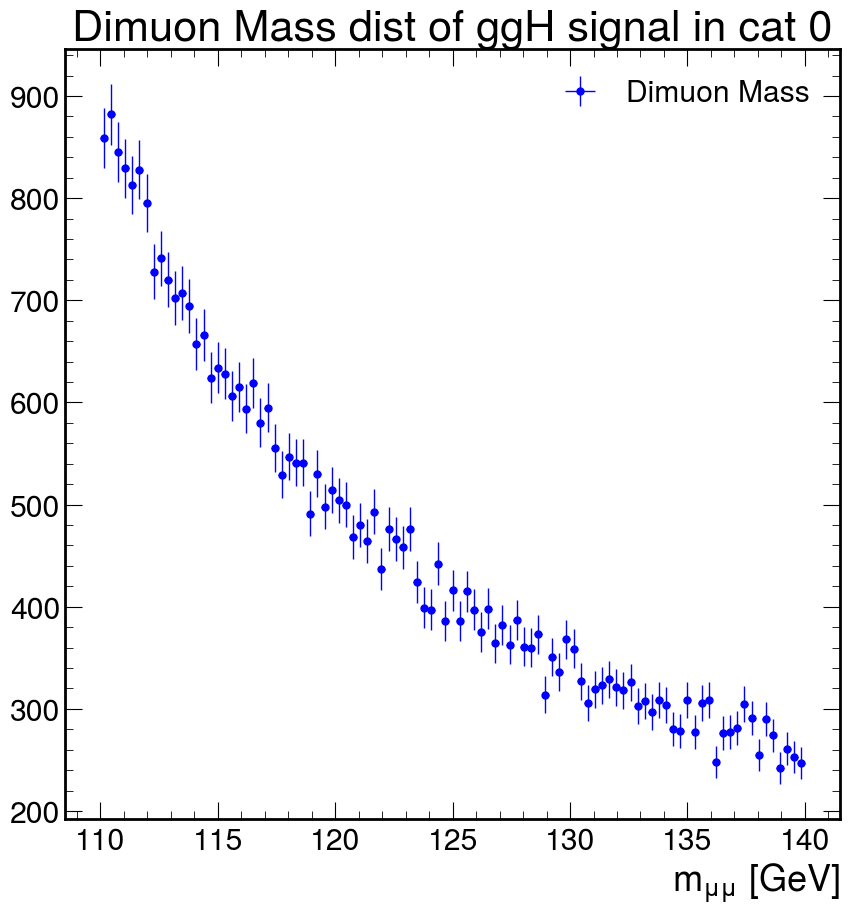

<Figure size 1000x1000 with 0 Axes>

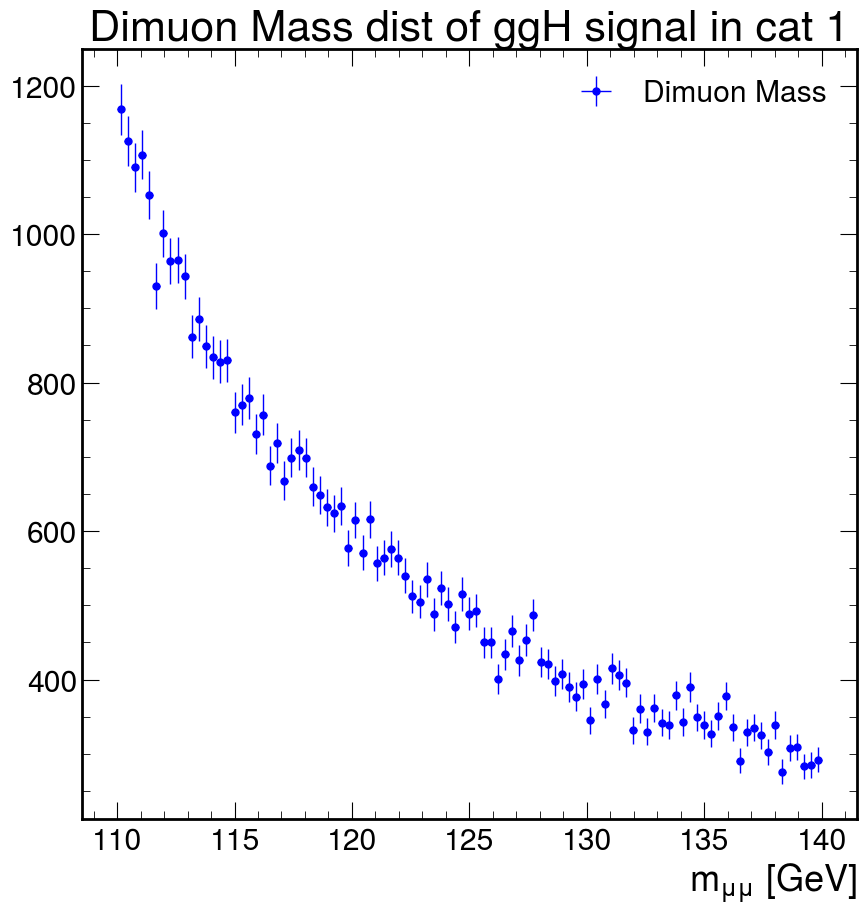

<Figure size 1000x1000 with 0 Axes>

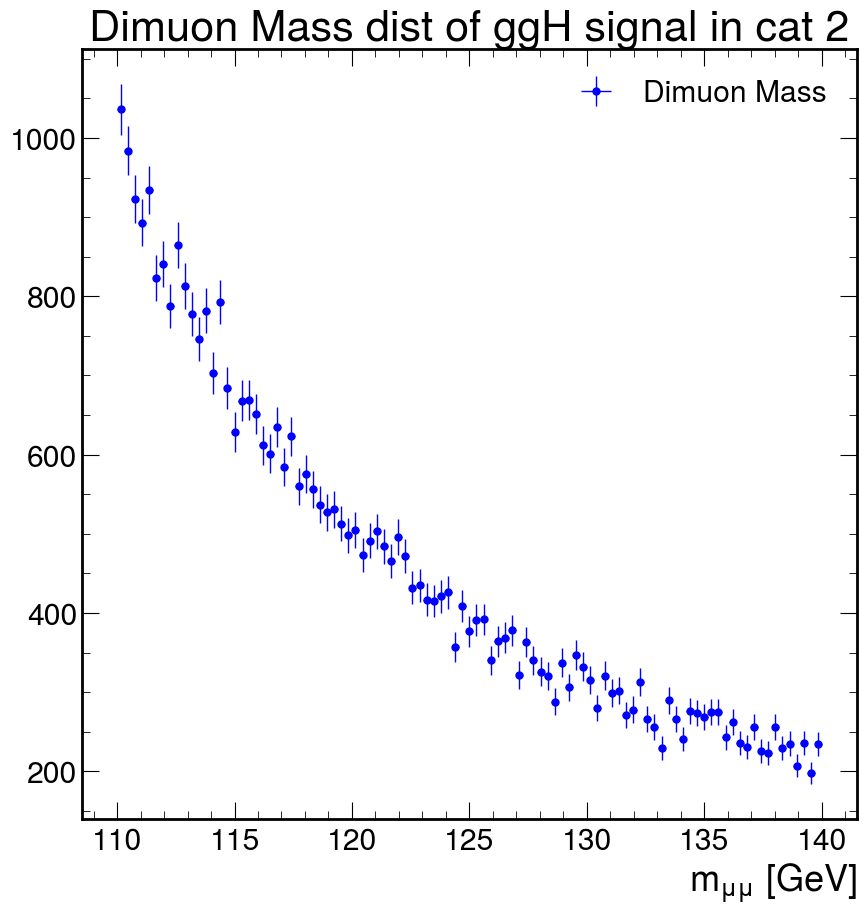

<Figure size 1000x1000 with 0 Axes>

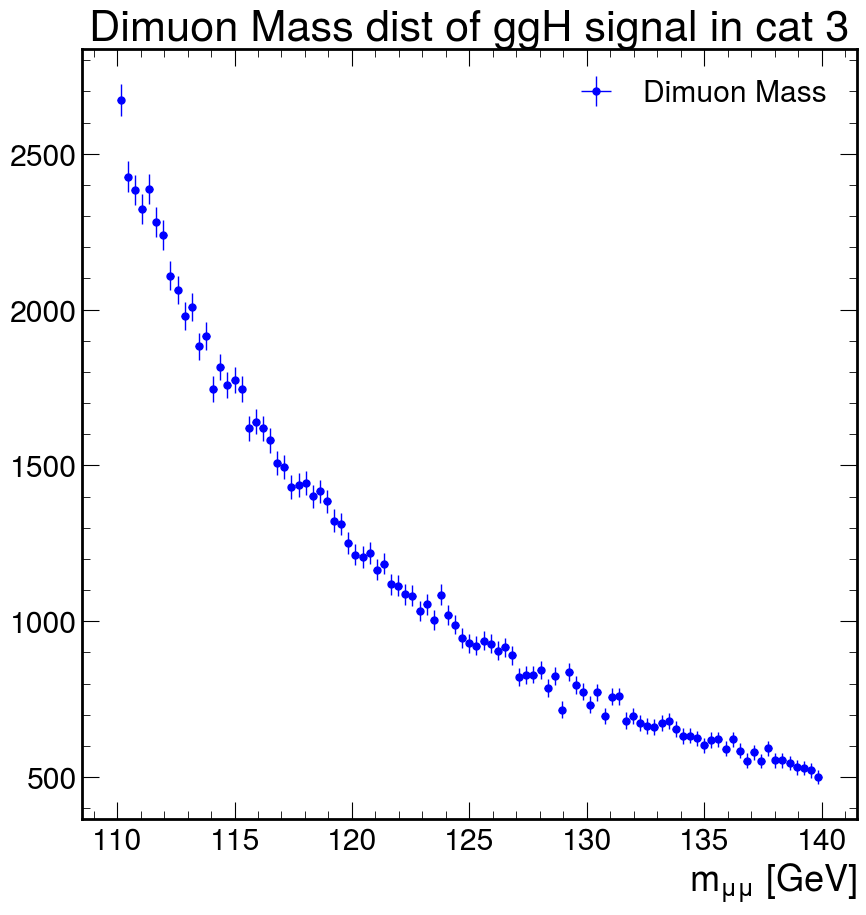

<Figure size 1000x1000 with 0 Axes>

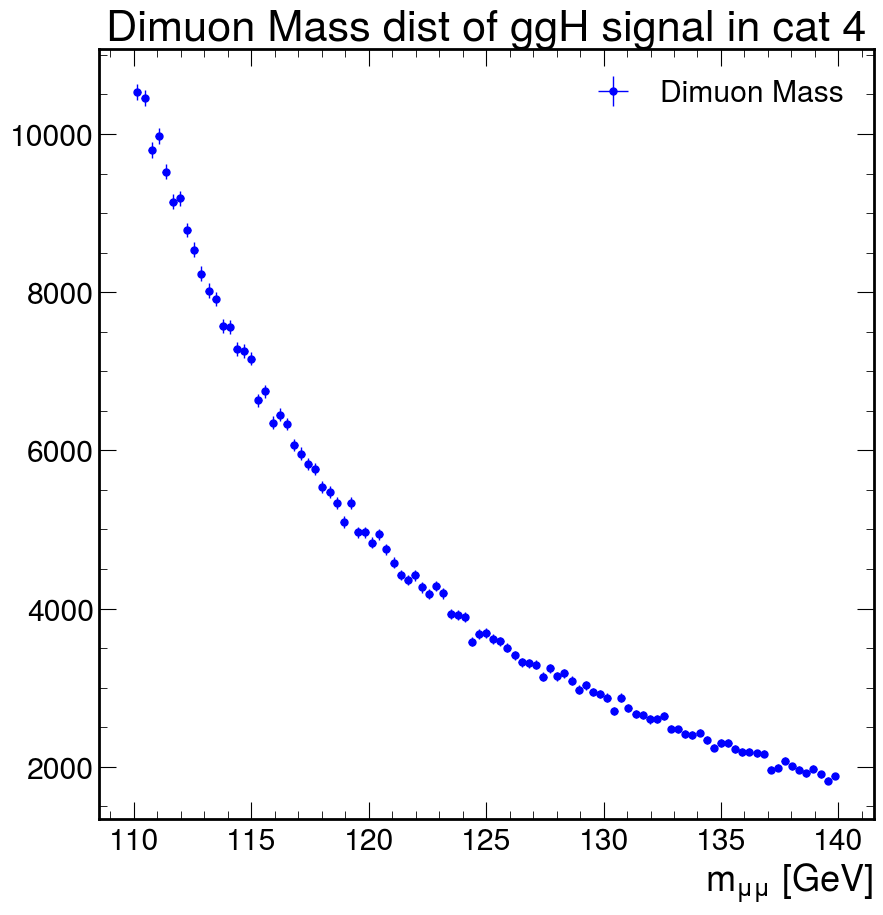

<Figure size 1000x1000 with 0 Axes>

In [30]:
"""
plot dimuon mass histogram
"""
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)


binning = np.linspace(110, 140, 100)
for ix in range(5):
    fig, ax_main = plt.subplots()
    subCat_filter = (processed_events["subCategory_idx"] == ix)
    dimuon_mass = processed_events.dimuon_mass[subCat_filter]
    weight = processed_events.wgt_nominal_total[subCat_filter]
    hist, edges = np.histogram(dimuon_mass, bins=binning, weights= weight)
    hist_w2, _ = np.histogram(dimuon_mass, bins=binning, weights= weight*weight)
    err_hist = np.sqrt(hist_w2) # all of data has weight=1
    hep.histplot(hist, bins=binning, 
         histtype='errorbar', 
        label="Dimuon Mass", 
         xerr=True, 
         yerr=err_hist,
        color = "blue",
        ax=ax_main
    )
    # # add in Half Max horizontal line for determining FWHM
    # halfMax = np.ones_like(hist) * 0.5*np.max(hist)
    # hep.histplot(
    #     halfMax, 
    #     bins=binning, 
    #      histtype='step', 
    #     label="Half-Max Line", 
    #      # xerr=True, 
    #      # yerr=err_hist,
    #     color = "red",
    #     ax=ax_main
    # )
    ax_main.set_xlabel("$m_{\mu\mu}$ [GeV]")
    plt.legend(loc="upper right")
    plt.title(f"Dimuon Mass dist of ggH signal in cat {ix}")
    # plt.savefig(f"./quick_plots/ggH_DimuMass_cat{ix}.pdf")
    plt.show()
    plt.clf()

In [39]:
A =rt.RooRealVar("coeff", "coeff", 0.01, 0.00000001, 1)
A.GetName()

'coeff'

In [ ]:
"""
time to fit 
"""
cat = rt.RooCategory("pdf_index","Index of Pdf which is active")
pdflist = rt.RooArgList()
# Make a RooMultiPdf object. The order of the pdfs will be the order of their index, ie for below
# 0 == exponential
# 1 == polynomial
# 2 == powerlaw
mypdfs.add(exponential)
mypdfs.add(polynomial)
mypdfs.add(powerlaw)

multipdf = rt.RooMultiPdf(
    # f"multipdf_{self.channel}_{category}", 
    "multipdf",
    "multipdf", 
    cat, 
    pdflist
)

In [23]:
model_path = "/depot/cms/hmm/vscheure/data/trained_models/BDTv12_2018/BDTv12_2018_0.pkl"
bdt_model = pickle.load(open(model_path, "rb"))

In [5]:
bdt_model.save_model("model-0.json")

# dump model with feature map
bdt_model.get_booster().dump_model("dump.nice.txt")

In [4]:
# ! pip list


In [21]:
import pandas as pd
nfolds = 4
test_df = pd.DataFrame(np.arange(100), columns=["event"])
for i in range(nfolds):
    # eval_folds are the list of test dataset chunks that each bdt is trained to evaluate
    eval_folds = [(i + f) % nfolds for f in [3]]
    print(eval_folds)
    eval_filter = test_df.event.mod(nfolds).isin(eval_folds)
    # print(f"eval_filter : {eval_filter}")
    eval_filter2 = (test_df.event % nfolds ) == (np.array(eval_folds) * np.ones_like(test_df.event))
    # print(f"eval_filter2 : {eval_filter2}")
    print(np.all(eval_filter == eval_filter2))

[3]
True
[0]
True
[1]
True
[2]
True


In [12]:
test_df

,0
0,0
1,1
2,2
3,3
4,4
...,...
95,95
96,96
97,97
98,98


In [16]:
95 % 4


3

In [56]:
np.inf

inf

In [90]:
type(ak.Array([[2,2],[1]]))

awkward.highlevel.Array

In [89]:
ak.Array([[2,2],[1]])

<Array [[2, 2], [1]] type='2 * var * int64'>

In [ ]:
# (ak.to_arrow(events, categorical_as_dictionary=False))
# ak.to_numpy(ak.Array(events))
# events.show()
# np.array(ak.unzip(events))

In [ ]:
ak.unzip(events[0,:])

In [128]:
training_features = [
        'dimuon_cos_theta_cs', 'dimuon_dEta', 'dimuon_dPhi', 'dimuon_dR', 'dimuon_eta', 'dimuon_phi', 'dimuon_phi_cs', 'dimuon_pt', 
        'dimuon_pt_log', 'jet1_eta', 'jet1_phi', 'jet1_pt', 'jet1_qgl', 'jet2_eta', 'jet2_phi', 
        'jet2_pt', 'jet2_qgl', 'jj_dEta', 'jj_dPhi', 'jj_eta', 'jj_mass', 'jj_mass_log', 
        'jj_phi', 'jj_pt', 'll_zstar_log', 'mmj1_dEta', 'mmj1_dPhi', 'mmj2_dEta', 'mmj2_dPhi', 
        'mmj_min_dEta', 'mmj_min_dPhi', 'mmjj_eta', 'mmjj_mass', 'mmjj_phi', 'mmjj_pt', 'mu1_eta', 'mu1_iso', 
        'mu1_phi', 'mu1_pt_over_mass', 'mu2_eta', 'mu2_iso', 'mu2_phi', 'mu2_pt_over_mass', 'zeppenfeld'
    ]
len(training_features)

44

In [145]:
A = np.arange(10)
A = A.reshape((2,5))
print(A)
print(np.transpose(A))

[[0 1 2 3 4]
 [5 6 7 8 9]]
[[0 5]
 [1 6]
 [2 7]
 [3 8]
 [4 9]]


In [12]:
test_input  = ak.concatenate([events[field][:, np.newaxis] for field in events.fields], axis=1)

In [13]:
test_input

<Array [[-0.737, 1.26, 2.26, ..., 1, 141], ...] type='5253810 * 47 * ?float64'>

In [15]:
events.dimuon_dEta

<Array [1.26, 16.9, 22.8, 18.2, ..., 3.6, 3.91, 6.71] type='5253810 * ?float64'>